<a href="https://colab.research.google.com/github/PaskahPrabu/alitomate-bangkit-capstone-2022/blob/main/ML/Alitomate_Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
import zipfile
import shutil
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

### **Preparing the Dataset**

For the dataset, we use images that have already been collected and saved to a personal drive. But if you want to give this model a try, we've also included a dataset from Github.

#### Dataset from Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dir = '/content/drive/MyDrive/Capstone/ML/Dataset'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Valid'))

print("\nContents of test directory:")
print(os.listdir(f'{base_dir}/Test'))

Contents of base directory:
['Test', 'Valid', 'Train']

Contents of train directory:
['Neutral', 'Fire']

Contents of validation directory:
['Fire', 'Neutral']

Contents of test directory:
['Fire', 'Neutral']


In [5]:
train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# Directory with training fire/neutral pictures
train_fire_dir = os.path.join(train_dir, 'Fire')
train_neutral_dir = os.path.join(train_dir, 'Neutral')

# Directory with validation fire/neutral pictures
valid_fire_dir = os.path.join(valid_dir, 'Fire')
valid_neutral_dir = os.path.join(valid_dir, 'Neutral')

# Directory with validation fire/neutral pictures
test_fire_dir = os.path.join(test_dir, 'Fire')
test_neutral_dir = os.path.join(test_dir, 'Neutral')

In [6]:
print('total training fire images :', len(os.listdir(train_fire_dir) ))
print('total training neutral images :', len(os.listdir(train_neutral_dir) ))

print('total validation fire images :', len(os.listdir(valid_fire_dir) ))
print('total validation neutral images :', len(os.listdir(valid_neutral_dir) ))

print('total test fire images :', len(os.listdir(test_fire_dir) ))
print('total test neutral images :', len(os.listdir(test_neutral_dir) ))

total training fire images : 900
total training neutral images : 900
total validation fire images : 100
total validation neutral images : 100
total test fire images : 75
total test neutral images : 75


#### Dataset from Github

In [ ]:
!wget https://github.com/DeepQuestAI/Fire-Smoke-Dataset/releases/download/v1/FIRE-SMOKE-DATASET.zip

In [ ]:
# Unzip the archive
local_zip = './FIRE-SMOKE-DATASET.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [ ]:
# Removing Smoke Image
shutil.rmtree('/content/FIRE-SMOKE-DATASET/Test/Smoke')
shutil.rmtree('/content/FIRE-SMOKE-DATASET/Train/Smoke')

In [ ]:
base_dir = 'FIRE-SMOKE-DATASET'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/Test'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/Train'))

In [ ]:
train_dir = os.path.join(base_dir, 'Train')
valid_dir = os.path.join(base_dir, 'Test')

# Directory with training fire/neutral pictures
train_fire_dir = os.path.join(train_dir, 'Fire')
train_neutral_dir = os.path.join(train_dir, 'Neutral')

# Directory with validation fire/neutral pictures
valid_fire_dir = os.path.join(valid_dir, 'Fire')
valid_neutral_dir = os.path.join(valid_dir, 'Neutral')

In [ ]:
train_fire_fnames = os.listdir(train_fire_dir )
train_neutral_fnames = os.listdir(train_neutral_dir )

print(train_fire_fnames[:10])
print(train_neutral_fnames[:10])

In [ ]:
print('total training fire images :', len(os.listdir(train_fire_dir) ))
print('total training neutral images :', len(os.listdir(train_neutral_dir) ))

print('total validation fire images :', len(os.listdir(valid_fire_dir) ))
print('total validation neutral images :', len(os.listdir(valid_neutral_dir) ))

### **Preprocessing Image**

In [7]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                    horizontal_flip=True,)
valid_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(224,224))     

validation_generator =  valid_datagen.flow_from_directory(valid_dir,
                                                         batch_size=16,
                                                         class_mode  = 'categorical',
                                                         target_size = (224,224))

test_generator =  valid_datagen.flow_from_directory(test_dir,
                                                    batch_size=16,
                                                    class_mode  = 'categorical',
                                                    target_size = (224,224))

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


### **Model**

#### Build Model

In [13]:
# Build the model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 224x224 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)      

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Train Model

In [16]:
# Train the model
history = model.fit(train_generator,
                    epochs=20,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
57/57 [==============================] - 14s 231ms/step - loss: 0.5518 - accuracy: 0.7172 - val_loss: 0.4971 - val_accuracy: 0.7500
Epoch 2/20
57/57 [==============================] - 12s 213ms/step - loss: 0.3522 - accuracy: 0.8433 - val_loss: 0.4202 - val_accuracy: 0.8200
Epoch 3/20
57/57 [==============================] - 12s 212ms/step - loss: 0.2672 - accuracy: 0.8917 - val_loss: 0.4259 - val_accuracy: 0.8250
Epoch 4/20
57/57 [==============================] - 12s 208ms/step - loss: 0.2451 - accuracy: 0.9011 - val_loss: 0.4870 - val_accuracy: 0.8350
Epoch 5/20
57/57 [==============================] - 12s 210ms/step - loss: 0.2062 - accuracy: 0.9250 - val_loss: 0.4515 - val_accuracy: 0.8550
Epoch 6/20
57/57 [==============================] - 12s 211ms/step - loss: 0.1890 - accuracy: 0.9317 - val_loss: 0.4419 - val_accuracy: 0.8300
Epoch 7/20
57/57 [==============================] - 12s 212ms/step - loss: 0.1754 - accuracy: 0.9300 - val_loss: 0.6254 - val_accuracy: 0.8350

#### Evaluate Model

In [17]:
model.evaluate(test_generator)

10/10 [==============================] - 1s 66ms/step - loss: 0.5094 - accuracy: 0.8600


[0.509364902973175, 0.8600000143051147]

#### Graph

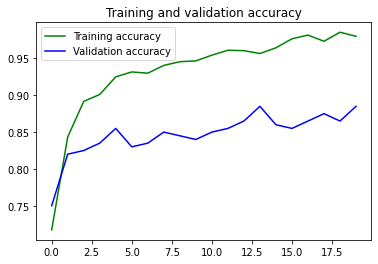

<Figure size 432x288 with 0 Axes>

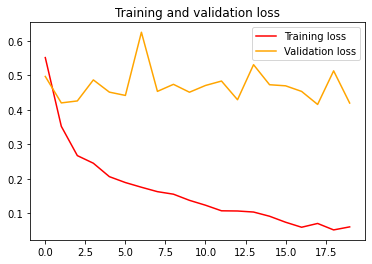

<Figure size 432x288 with 0 Axes>

In [26]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

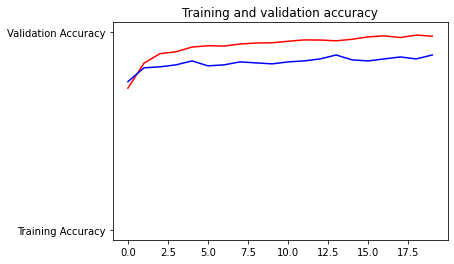

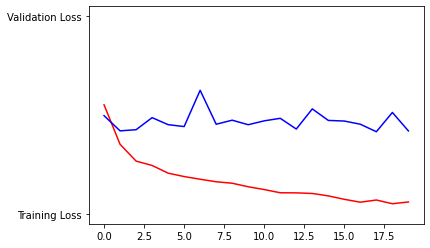

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

### **Predicting Image**

Saving rumah-murah_169.jpeg to rumah-murah_169.jpeg


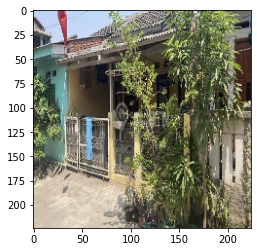

False 0.99947244
There is no Fire


In [22]:
#predicting any random image
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  imgplot = plt.imshow(img)
  plt.show()
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0) /255
  classes = model.predict(x)
  fire = np.argmax(classes[0])==0
  print(fire, max(classes[0]))
  if fire == False:
    print("There is no Fire")
  else:
    print("There is Fire")

### **Save Model and Convert to Tensorflow Lite**

In [28]:
model.save('fire_classification_alitomate.h5')

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpg5l6n8xg/assets
